NESTML Tutorial (CNS2020)
==========================================

## **Exercise:** Implementing and evaluating intrinsic adaptation models

In this exercise, we will use NESTML to implement variants of intrinsic plasticity mechanisms and evaluate their impact on single neuron and population dynamics and information encoding.

We will go step-by-step through adding two different types of SFA mechanisms to a neuron model [[1](https://dx.doi.org/10.1007%2Fs11571-018-9504-2)], and evaluating the outcome.

**References:**

[[1](https://dx.doi.org/10.1007%2Fs11571-018-9504-2)] - Victor J. Barranca, Han Huang, and Sida Li. The impact of spike-frequency adaptation on balanced network dynamics. Cogn Neurodyn. 2019 Feb; 13(1): 105–120.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import itertools

from helper import SpikeList
from pynestml.frontend.pynestml_frontend import to_nest, install_nest

### **1. Single Neuron Dynamics**

We will start by defining a set of routines to evaluate the properties of neuronal responses:

In [2]:
def evaluate_neuron(neuron_name):
    dt = 1.   # [ms]
    t_simulation = 300. # [ms]

    nest.ResetKernel()
    
    neuron = nest.Create(neuron_name)
    nest.SetStatus(neuron, "I_e", 500.)
    multimeter = nest.Create("multimeter")
    nest.SetStatus(multimeter, {"record_from": ["V_m"],
                    "interval": dt})
    spikedetector = nest.Create("spike_detector")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spikedetector)
    
    nest.Simulate(t_simulation)

    dmm = nest.GetStatus(multimeter)[0]
    Voltages = dmm["events"]["V_m"]
    tv = dmm["events"]["times"]
    dSD = nest.GetStatus(spikedetector, keys='events')[0]
    spikes = dSD['senders']
    ts = dSD["times"]
    
    fig, ax = plt.subplots()
    ax.plot(tv, Voltages)
    ax.grid()
    ax.set_xlim([0., t_simulation])

Now, we will implement and compare the different neuron models:

#### a) Base model, no adaptation:

In [3]:
# to_nest(input_path="/home/charl/julich/nestml-upstream/nestml/models_for_sra/iaf_psc_alpha.nestml",
#         target_path="/tmp/nestml-target",
#         module_name="nestml_iaf_psc_alpha_module",
#         suffix="_nestml")
# install_nest("/tmp/nestml-target", "/home/charl/julich/nest-simulator-build")
# nest.Install("nestml_iaf_psc_alpha_module")

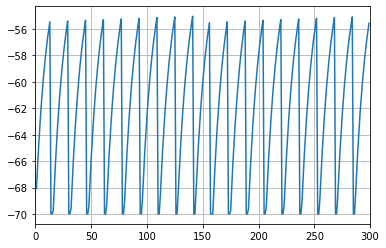

In [4]:
evaluate_neuron("iaf_psc_alpha") # evaluate_neuron("iaf_psc_alpha_nestml")

#### b) Threshold-based adaptation:

One of the options we will explore adds spike-frequency adaptation by increasing the firing threshold $\Theta$ by $\Delta\Theta$ the moment the neuron fires. Between firing events, $\Theta$ evolves according to:

\begin{align}
\frac{d\Theta}{dt} &= -(\Theta - \Theta_{init}) / \tau_\Theta
\end{align}

such that the firing threshold decays to its baseline value, in the absence of firing events, and $\tau_\Theta$ determines the decay rate.

In [5]:
# to_nest(input_path="/home/charl/julich/nestml-upstream/nestml/models_for_sra/iaf_psc_alpha_adapt_thresh.nestml",
#         target_path="/tmp/nestml-target",
#         module_name="nestml_sra_adapt_thresh_module",
#         suffix="_nestml",
#         logging_level="INFO")
# install_nest("/tmp/nestml-target", "/home/charl/julich/nest-simulator-build")
# nest.Install("nestml_sra_adapt_thresh_module")

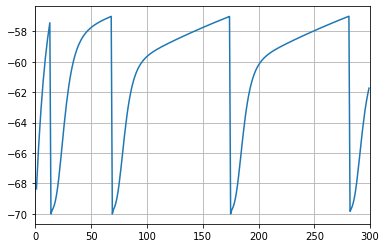

In [6]:
evaluate_neuron("iaf_cond_exp_sfa_rr") #evaluate_neuron("iaf_psc_alpha_adapt_thresh_nestml")

#### c) Current-based adaptation

A different approach is to incorporate an adaptation current $I_{sra}(t)$ while keeping the firing threshold constant. The dynamical system model is adjusted in this case to:

\begin{align}
\frac{dV_m}{dt} &= -(I_{syn} + I_{ext} + I_{sra}) / \tau_m\\
\frac{dI_{sra}}{dt} &= -I_{sra} / \tau_{sra}
\end{align}

where $I_{sra}$ is instantaneously increased by $\Delta{}I_{sra}$ at each the neuron fires and $\tau_{sra}$ controls the decay rate for the adaptation current.

In [7]:
# to_nest(input_path="/home/charl/julich/nestml-upstream/nestml/models_for_sra/iaf_psc_alpha_spike_rate_adapt.nestml",
#         target_path="/tmp/nestml-target",
#         module_name="nestml_sra_curr_module",
#         suffix="_nestml",
#         logging_level="INFO")
# install_nest("/tmp/nestml-target", "/home/charl/julich/nest-simulator-build")
# nest.Install("nestml_sra_curr_module")

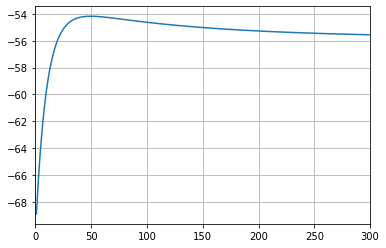

In [8]:
evaluate_neuron("aeif_cond_alpha") #evaluate_neuron("iaf_psc_alpha_spike_rate_adapt_nestml")

#### d) Slope-dependent threshold

As an extra challenge: implement the slope-dependent threshold from https://www.pnas.org/content/97/14/8110

----

#### **1.1. Single Neuron Characterization**

To further characterize the different neuron models described above, we will evaluate their transfer functions in the presence of current and rate inputs. For each analysis, we will measure the neuron's output firing rates, $CV_{ISI}$ and autocorrelation:

In [9]:
def measure_fI_curve(I_stim_vec, neuron_model_name):
    t_stop = 10000.   # simulate for a long time to make any startup transients insignificant [ms]

    rates = np.zeros_like(I_stim_vec)
    cvs = float("nan") * np.ones_like(I_stim_vec)
    corr = float("nan") * np.ones_like(I_stim_vec)
    
    for i, I_stim in enumerate(I_stim_vec):
        nest.ResetKernel()
        neuron = nest.Create(neuron_model_name)

        dc = nest.Create("dc_generator", params={"amplitude": I_stim * 1E12}) # 1E12: convert A to pA
        nest.Connect(dc, neuron)

        sd_testant = nest.Create('spike_detector')
        nest.Connect(neuron, sd_testant)

        nest.Simulate(t_stop)

        activity = nest.GetStatus(sd_testant, 'events')[0]
        tmp = [(k, t) for k, t in zip(activity['senders'], activity['times'])]
        sl = SpikeList(tmp, list(np.unique(activity['senders'])), t_start=0., t_stop=t_stop)
        
        if not sl.empty():
            rates[i] = sl.mean_rate()
            cvs[i] = np.nanmean(sl.cv_isi())
            corr[i] = np.mean(sl.autocorrelations())
    return rates, cvs, corr

In [10]:
def measure_rate_transfer(rate_stim_vec, neuron_model_name, wE):
    t_stop = 10000.
    
    rates = np.zeros_like(rate_stim_vec)
    cvs = float("nan") * np.ones_like(rate_stim_vec)
    corr = float("nan") * np.ones_like(rate_stim_vec)
    for i, stim in enumerate(rate_stim_vec):
        nest.ResetKernel()
        neuron = nest.Create(neuron_model_name)

        pg = nest.Create("poisson_generator", params={"rate": stim * 1E3}) # 1E3: consider independent processes from 1E3 sources
        nest.Connect(pg, neuron, syn_spec={'delay': 1.5, 'weight': wE})

        sd_testant = nest.Create('spike_detector')
        nest.Connect(neuron, sd_testant)

        nest.Simulate(t_stop)
        
        activity = nest.GetStatus(sd_testant, 'events')[0]
        tmp = [(k, t) for k, t in zip(activity['senders'], activity['times'])]
        sl = SpikeList(tmp, list(np.unique(activity['senders'])), t_start=0., t_stop=t_stop)
        
        if not sl.empty():
            rates[i] = sl.mean_rate()
            cvs[i] = np.nanmean(sl.cv_isi())
            corr[i] = np.mean(sl.autocorrelations())

    return rates, cvs, corr

In [11]:
def plot_IOcurves(I_stim_vec, label_to_rate_vec, ax=None, xlabel="", ylabel=""):
    if len(I_stim_vec) < 20:
        marker = "o"
    else:
        marker = None
    if ax is None:
        fig, ax = plt.subplots()
    ax = [ax]
    if isinstance(I_stim_vec, dict):
        for label, rate_vec in label_to_rate_vec.items():
            ax[0].plot(I_stim_vec[label], rate_vec, marker=marker, label=label)
    else:
        for label, rate_vec in label_to_rate_vec.items():
            ax[0].plot(I_stim_vec, rate_vec, marker=marker, label=label)
    for _ax in ax:
        _ax.legend(loc='upper right')
        _ax.grid()
        _ax.set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    plt.tight_layout()
    return ax[0]

We can now perform the analysis for the different neuron models:

**1. fI curves:**

<ipython-input-9-ab6137f05168>:26: RuntimeWarning:Mean of empty slice
/home/neuro/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning:Mean of empty slice.
/home/neuro/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


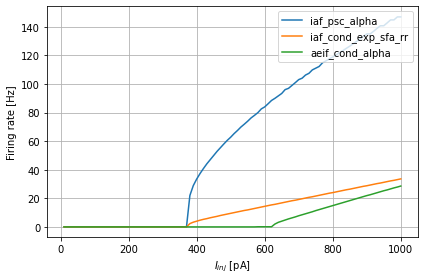

In [12]:
neuron_models = ["iaf_psc_alpha", "iaf_cond_exp_sfa_rr", "aeif_cond_alpha"] # "iaf_psc_alpha_nestml", "iaf_psc_alpha_spike_rate_adapt_nestml", "iaf_psc_alpha_adapt_thresh_nestml"
I_stim_vec = np.linspace(10E-12, 1E-9, 100)     # [A]
fI_curves = {}
cv_curves = {}
acc_curves = {}

for neuron in neuron_models:
    rate_vec, cvs_vec, acorr_vec = measure_fI_curve(I_stim_vec, neuron)
    fI_curves.update({neuron: rate_vec})
    cv_curves.update({neuron: cvs_vec})
    acc_curves.update({neuron: acorr_vec})

plot_IOcurves(I_stim_vec*1E12, fI_curves, xlabel="$I_{inj}$ [pA]", ylabel="Firing rate [Hz]")

**2. Rate transfer functions:**

<ipython-input-10-04fdb4456adb>:25: RuntimeWarning:Mean of empty slice
/home/neuro/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning:Mean of empty slice.
/home/neuro/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


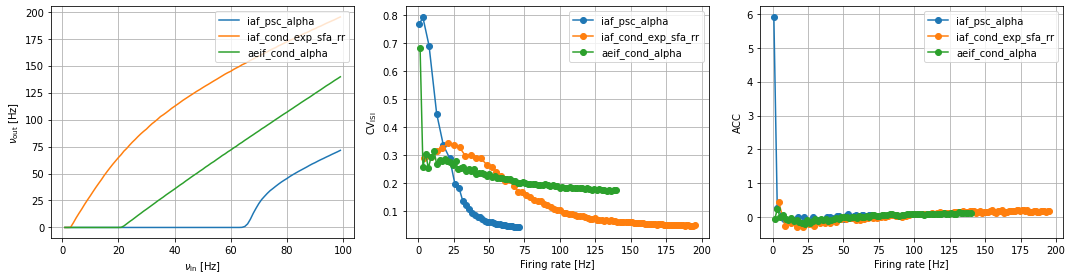

In [13]:
neuron_models = ["iaf_psc_alpha", "iaf_cond_exp_sfa_rr", "aeif_cond_alpha"] # "iaf_psc_alpha_nestml", "iaf_psc_alpha_spike_rate_adapt_nestml", "iaf_psc_alpha_adapt_thresh_nestml"
stim_vec = np.arange(1., 100., 1.)    # [Hz]
rate_curves = {}
cv_curves = {}
acc_curves = {}

for neuron in neuron_models:
    rate_vec, cvs_vec, acorr_vec = measure_rate_transfer(stim_vec, neuron, wE=1.)
    rate_curves.update({neuron: rate_vec})
    cv_curves.update({neuron: cvs_vec})
    acc_curves.update({neuron: acorr_vec})

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
plot_IOcurves(stim_vec, rate_curves, ax=ax[0], xlabel=r"$\nu_{\mathrm{in}}$ [Hz]", ylabel=r"$\nu_{\mathrm{out}}$ [Hz]")
plot_IOcurves(rate_curves, cv_curves, ax=ax[1], xlabel="Firing rate [Hz]", ylabel=r"$\mathrm{CV_{ISI}}$")
plot_IOcurves(rate_curves, acc_curves, ax=ax[2], xlabel="Firing rate [Hz]", ylabel=r"$\mathrm{ACC}$")

### **2. Balanced Network Dynamics**

As with the single neuron experiments, we will start by defining a set of routines to evaluate the properties of population responses:

In [14]:
def reset_nest_kernel(seed, num_threads, dt):
    np.random.seed(seed)
    nest.ResetKernel()
    nest.SetKernelStatus({'grng_seed': seed, 'resolution': dt, 'print_time': True, 'local_num_threads': num_threads})

In [15]:
def create_network(neuron_model, N=1000, epsilon=0.1, wE=1., gamma=12.):    
    # network parameters
    nE = int(N * 0.8)
    nI = int(N * 0.2)
    
    # create populations and randomize inital states
    neurons_e = nest.Create(neuron_model, nE)
    vm0 = np.random.uniform(**{'low': nest.GetStatus([neurons_e[0]])[0]['E_L'], 'high': nest.GetStatus([neurons_e[0]])[0]['V_th'], 'size': nE})
    nest.SetStatus(neurons_e, params='V_m', val=list(vm0))

    neurons_i = nest.Create(neuron_model, nI)
    vm0 = np.random.uniform(**{'low': nest.GetStatus([neurons_i[0]])[0]['E_L'], 'high': nest.GetStatus([neurons_i[0]])[0]['V_th'], 'size': nI})
    nest.SetStatus(neurons_i, params='V_m', val=list(vm0))

    # connect
    syn_exc = {'delay': 1.5, 'weight': wE}
    conn_exc = {'rule': 'pairwise_bernoulli', 'p': epsilon}
    nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc) # E->E
    nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc) # E->I
    
    syn_inh = {'delay': 1.5, 'weight': - gamma * wE}
    conn_inh = {'rule': 'pairwise_bernoulli', 'p': epsilon}
    nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh) # I->E
    nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh) # I->I
       
    return neurons_e, neurons_i, syn_exc, syn_inh

In [16]:
def set_recording_devices(neurons_e, neurons_i, start=0., stop=1000.):
    spikes_e = nest.Create('spike_detector')
    nest.SetStatus(spikes_e, {'start': start, 'stop': stop})
    spikes_i = nest.Create('spike_detector')
    nest.SetStatus(spikes_i, {'start': start, 'stop': stop})

    nest.Connect(neurons_e, spikes_e)
    nest.Connect(neurons_i, spikes_i)
    return spikes_e, spikes_i

In [17]:
def evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec, p_rate=5000., start=0., stop=1000.):
    
    noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'start': start, 'stop': stop})

    # connect poisson generator using the excitatory connection weight
    nest.Connect(noise_pgen, neurons_i, syn_spec=syn_spec)
    nest.Connect(noise_pgen, neurons_e, syn_spec=syn_spec)
    
    nest.Simulate(stop-start)
    
    e_activity = nest.GetStatus(spikes_e, 'events')[0]
    i_activity = nest.GetStatus(spikes_i, 'events')[0]
    
    tmp = [(k, t) for k, t in zip(e_activity['senders'], e_activity['times'])]
    sl_e = SpikeList(tmp, list(np.unique(e_activity['senders'])), t_start=start, t_stop=stop)
    
    tmp = [(k, t) for k, t in zip(i_activity['senders'], i_activity['times'])]
    sl_i = SpikeList(tmp, list(np.unique(i_activity['senders'])), t_start=start, t_stop=stop)
    
    return sl_e, sl_i    

In [18]:
def characterize_population_activity(e_spike_list, i_spike_list, start=0., transient=100., stop=1000., title='', plot=True):
    e_spike_list = e_spike_list.time_slice(t_start=transient, t_stop=stop)
    i_spike_list = i_spike_list.time_slice(t_start=transient, t_stop=stop)
    
    ids = np.array(list(itertools.chain(*[e_spike_list.id_list, i_spike_list.id_list])))
    network_activity = e_spike_list.copy()
    network_activity.concatenate(i_spike_list)
    e_rates = np.array(e_spike_list.mean_rates())
    i_rates = np.array(i_spike_list.mean_rates())
    e_cvs = e_spike_list.cv_isi()
    i_cvs = i_spike_list.cv_isi()
    e_ccs = e_spike_list.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True)
    i_ccs = i_spike_list.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True)
    
    if plot:
        fig = plt.figure(figsize=(20, 10))
        fig.suptitle(title)
        ax1 = plt.subplot2grid((30, 20), (0, 0), rowspan=23, colspan=16)
        ax2 = plt.subplot2grid((30, 20), (24, 0), rowspan=5, colspan=16, sharex=ax1)
        ax2.set(xlabel='Time [ms]', ylabel='Rate')
        ax1.set(ylabel='Neuron')

        ax3 = plt.subplot2grid((30, 20), (0, 17), rowspan=10, colspan=10)
        ax4 = plt.subplot2grid((30, 20), (11, 17), rowspan=10, colspan=3)
        ax5 = plt.subplot2grid((30, 20), (22, 17), rowspan=10, colspan=3)

        ax1.plot(e_spike_list.raw_data()[:, 0], e_spike_list.raw_data()[:, 1], '.', c='b')
        ax1.plot(i_spike_list.raw_data()[:, 0], i_spike_list.raw_data()[:, 1], '.', c='r')
        ax1.set_xlim([start+transient, stop])
        ax1.set_ylim([ids.min(), ids.max()])

        ax2.plot(e_spike_list.time_axis(1.)[:-1], e_spike_list.firing_rate(1., average=True), lw=1, c='b', alpha=0.3)
        ax2.plot(i_spike_list.time_axis(1.)[:-1], i_spike_list.firing_rate(1., average=True), lw=1, c='r', alpha=0.3)
        ax2.plot(e_spike_list.time_axis(10.)[:-1], e_spike_list.firing_rate(10., average=True), lw=2, c='b')
        ax2.plot(i_spike_list.time_axis(10.)[:-1], i_spike_list.firing_rate(10., average=True), lw=2, c='r')
        ax2.set_xlim([start+transient, stop])

        _ = ax3.hist(e_rates[e_rates!=0.], color='b', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        _ = ax3.hist(i_rates[i_rates!=0.], color='r', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        ax3.set_xlabel("Firing rate [Hz]")

        _ = ax4.hist(e_cvs[~np.isnan(e_cvs)], color='b', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        _ = ax4.hist(i_cvs[~np.isnan(i_cvs)], color='r', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        ax4.set_xlabel(r"$\mathrm{CV_{ISI}}$")

        _ = ax5.hist(e_ccs[~np.isnan(e_ccs)], color='b', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        _ = ax5.hist(i_ccs[~np.isnan(i_ccs)], color='r', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        ax5.set_xlabel(r"$\mathrm{CC}$")
        plt.tight_layout()
    
    print("\n######## {} ########".format(title))
    print("- Mean firing rate: {0} spikes/s\n\tE = {1} spikes/s\n\tI = {2} spikes/s".format(
        network_activity.mean_rate(), e_spike_list.mean_rate(), i_spike_list.mean_rate()))
    print("- Mean CV_ISI: {0} \n\tE = {1} \n\tI = {2}".format(
        np.nanmean(network_activity.cv_isi()), np.nanmean(e_spike_list.cv_isi()), np.nanmean(i_spike_list.cv_isi())))
    print("- Mean Pairwise CC: {0} \n\tE = {1} \n\tI = {2}".format(
        network_activity.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1.)[0], 
        e_spike_list.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1.)[0], 
        i_spike_list.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1.)[0]))
    
    return e_spike_list, i_spike_list

We can now evaluate the population dynamics for the different neuron models

<ipython-input-18-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## iaf_psc_alpha ########
- Mean firing rate: 45.50998948475289 spikes/s
	E = 45.70263157894737 spikes/s
	I = 44.7434554973822 spikes/s
- Mean CV_ISI: 0.4017223399318341 
	E = 0.4041209623158156 
	I = 0.39212785039590786
- Mean Pairwise CC: 0.0021002323220814887 
	E = 0.005187614723757779 
	I = 0.008146694693496303


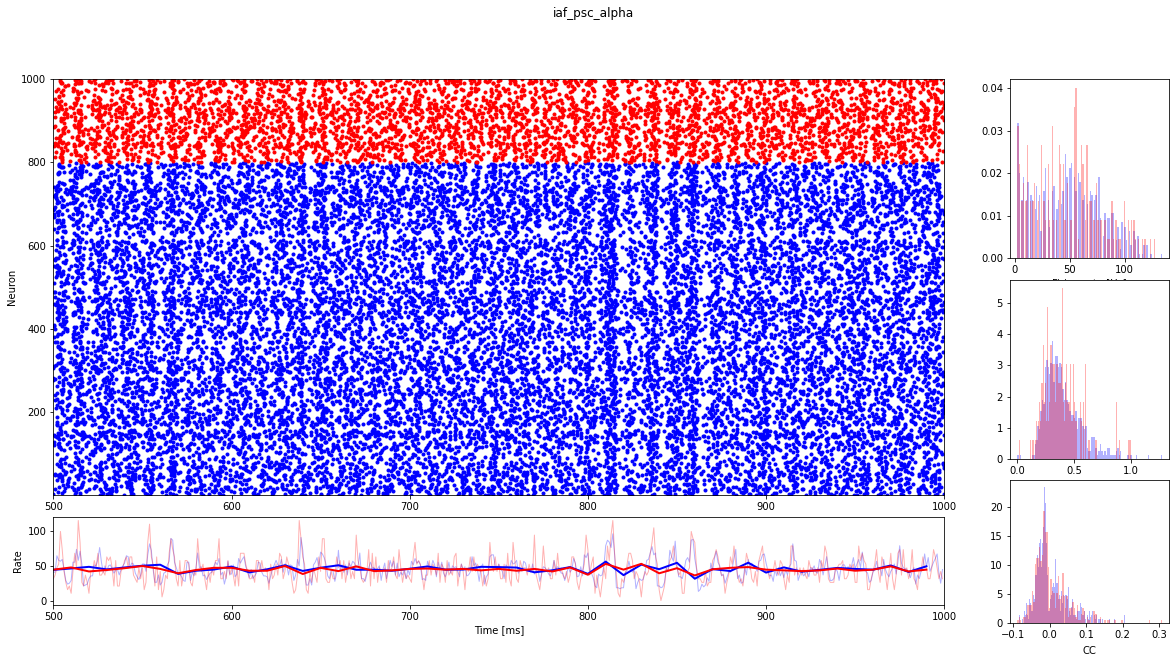

In [19]:
sim_time = 1000.
neuron_model = "iaf_psc_alpha"

reset_nest_kernel(seed=10, num_threads=16, dt=0.1)
neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1, wE=15., gamma=10.)
spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=sim_time)
e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=10000., start=0., stop=sim_time)
_ = characterize_population_activity(e_activity, i_activity, start=0., transient=500., stop=sim_time, title=neuron_model, plot=True)

<ipython-input-18-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## iaf_cond_exp_sfa_rr ########
- Mean firing rate: 48.23 spikes/s
	E = 48.315 spikes/s
	I = 47.89 spikes/s
- Mean CV_ISI: 0.8644256698487162 
	E = 0.8618012558199277 
	I = 0.875579429471067
- Mean Pairwise CC: 0.019600722779457975 
	E = 0.01497770856477019 
	I = 0.018804338978712202


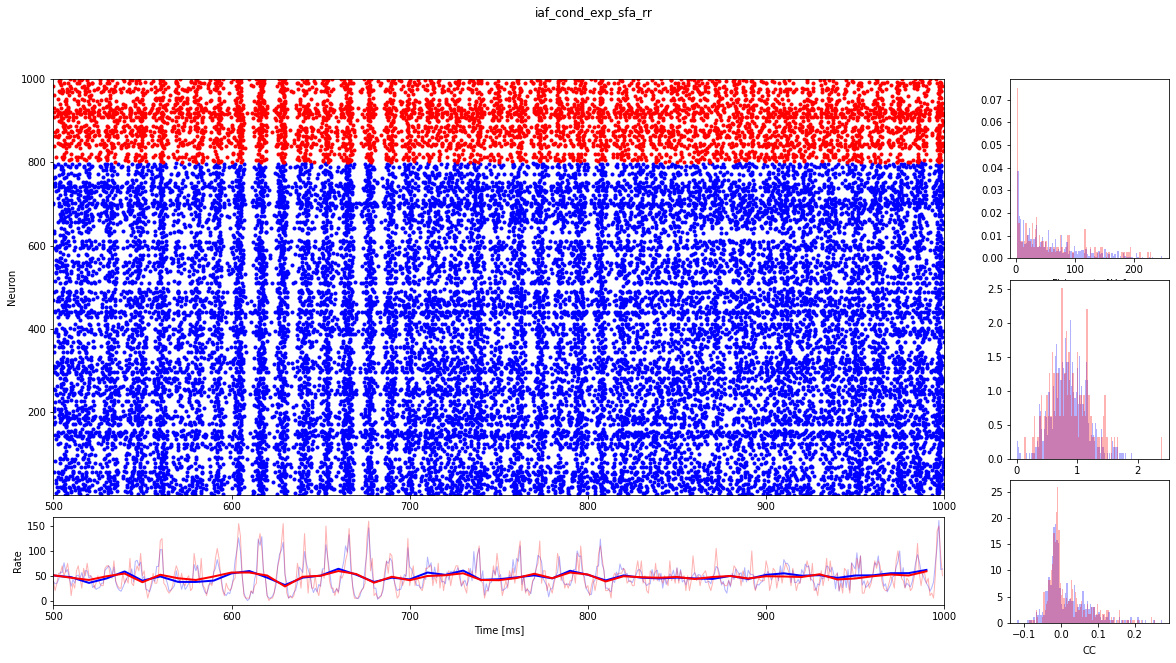

In [20]:
sim_time = 1000.
neuron_model = "iaf_cond_exp_sfa_rr"

reset_nest_kernel(seed=10, num_threads=16, dt=0.1)
neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1, wE=15., gamma=10.)
spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=sim_time)
e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=10000., start=0., stop=sim_time)
_ = characterize_population_activity(e_activity, i_activity, start=0., transient=500., stop=sim_time, title=neuron_model, plot=True)

<ipython-input-18-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## aeif_cond_alpha ########
- Mean firing rate: 4.794 spikes/s
	E = 4.765 spikes/s
	I = 4.91 spikes/s
- Mean CV_ISI: 0.36052025263248894 
	E = 0.3600363292361937 
	I = 0.3623062791878876
- Mean Pairwise CC: 0.005723934585705738 
	E = 0.0012132869420666608 
	I = 0.0028491138494264466


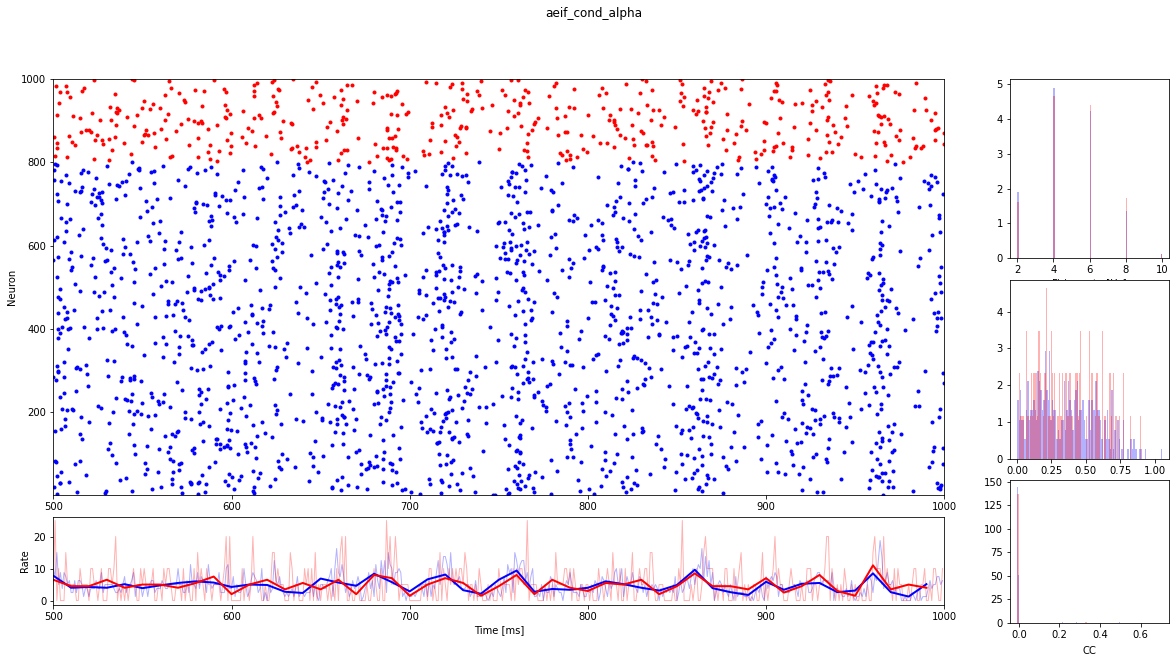

In [21]:
sim_time = 1000.
neuron_model = "aeif_cond_alpha"

reset_nest_kernel(seed=10, num_threads=16, dt=0.1)
neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1, wE=2.5, gamma=5.)
spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=sim_time)
e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=10000., start=0., stop=sim_time)
_ = characterize_population_activity(e_activity, i_activity, start=0., transient=500., stop=sim_time, title=neuron_model, plot=True)

To gain a better overview, let's look at the statistics of population activity for the different models, side-by-side:


######## iaf_psc_alpha ########
- Mean firing rate: 45.50998948475289 spikes/s
	E = 45.70263157894737 spikes/s
	I = 44.7434554973822 spikes/s
- Mean CV_ISI: 0.4017223399318341 
	E = 0.4041209623158156 
	I = 0.39212785039590786
- Mean Pairwise CC: 0.0021002323220814887 
	E = 0.005187614723757779 
	I = 0.008146694693496303

######## iaf_cond_exp_sfa_rr ########
- Mean firing rate: 48.23 spikes/s
	E = 48.315 spikes/s
	I = 47.89 spikes/s
- Mean CV_ISI: 0.8644256698487162 
	E = 0.8618012558199277 
	I = 0.875579429471067
- Mean Pairwise CC: 0.019600722779457975 
	E = 0.01497770856477019 
	I = 0.018804338978712202

######## aeif_cond_alpha ########
- Mean firing rate: 4.794 spikes/s
	E = 4.765 spikes/s
	I = 4.91 spikes/s
- Mean CV_ISI: 0.36052025263248894 
	E = 0.3600363292361937 
	I = 0.3623062791878876
- Mean Pairwise CC: 0.005723934585705738 
	E = 0.0012132869420666608 
	I = 0.0028491138494264466


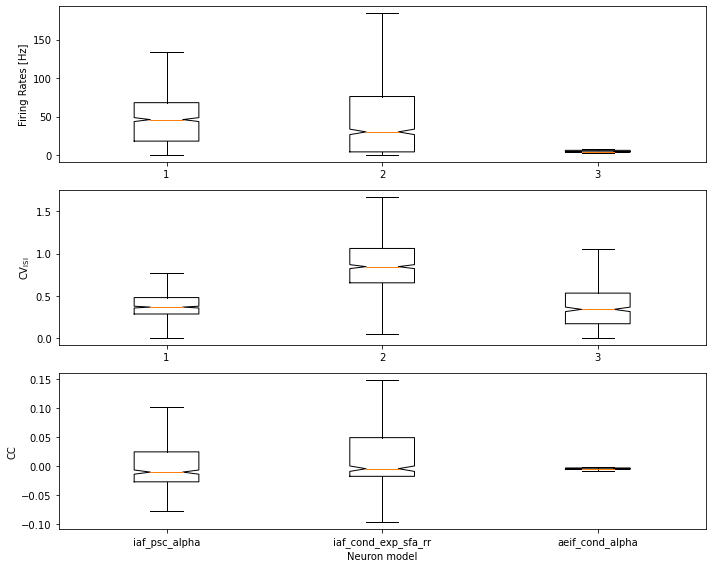

In [22]:
sim_time = 1000.
neuron_models = ["iaf_psc_alpha", "iaf_cond_exp_sfa_rr", "aeif_cond_alpha"]

rates = []
cvs = []
ccs = []

for neuron_model in neuron_models:
    reset_nest_kernel(seed=10, num_threads=16, dt=0.1)
    if neuron_model == "aeif_cond_alpha":
        wE, gamma = 2.5, 5.
    else:
        wE, gamma = 15., 10.
    neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1, wE=wE, gamma=gamma)
    spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=sim_time)
    e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=10000., start=0., stop=sim_time)
    e_activity, i_activity = characterize_population_activity(e_activity, i_activity, start=0., transient=500., stop=sim_time, title=neuron_model, plot=False)
    
    network_activity = e_activity.copy()
    network_activity.concatenate(i_activity)
    
    rates.append(network_activity.mean_rates())
    cvs.append(network_activity.cv_isi(True))
    ccs.append(network_activity.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True))

fig, ax = plt.subplots(3, 1, figsize=(10, 8))
pos = np.arange(1, len(neuron_models)+1, 1)
ax[0].boxplot(rates, notch=1, positions=pos, vert=1, sym='')
ax[0].set_ylabel("Firing Rates [Hz]")
ax[1].boxplot(cvs, notch=1, positions=pos, vert=1, sym='')
ax[1].set_ylabel(r"$\mathrm{CV_{ISI}}$")
ax[2].boxplot(ccs, notch=1, positions=pos, vert=1, sym='')
ax[2].set_ylabel("CC")
ax[2].set_xlabel('Neuron model')
ax[2].set_xticks(pos)
ax[2].set_xticklabels(neuron_models)
plt.tight_layout()

### **3. Rate perturbation**

We will now perform a simple experiment where we perturb the input firing rate and evaluate how the population adapts in the presence of the different intrinsic adaptation mechanisms

<ipython-input-18-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## Before ########
- Mean firing rate: 51.73030471943515 spikes/s
	E = 52.11226851851851 spikes/s
	I = 50.17655367231639 spikes/s
- Mean CV_ISI: 0.8641230889285604 
	E = 0.8697892564124075 
	I = 0.8406489664954798
- Mean Pairwise CC: 0.0036738486870058107 
	E = 0.003699406788395886 
	I = 0.004321377634010416


<ipython-input-18-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## After ########
- Mean firing rate: 55.331042442684016 spikes/s
	E = 55.765224489795926 spikes/s
	I = 53.55742296918767 spikes/s
- Mean CV_ISI: 0.7168811617180584 
	E = 0.718047707724541 
	I = 0.7120599820688888
- Mean Pairwise CC: 0.04617659013682726 
	E = 0.045908643043592906 
	I = 0.0446056875014694


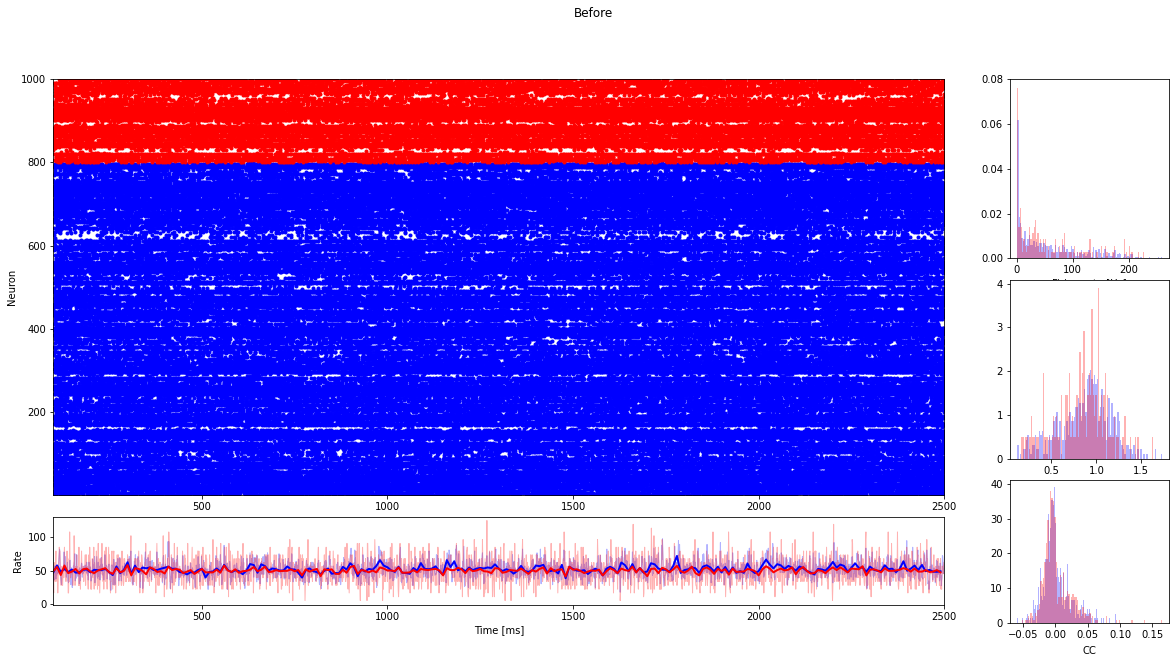

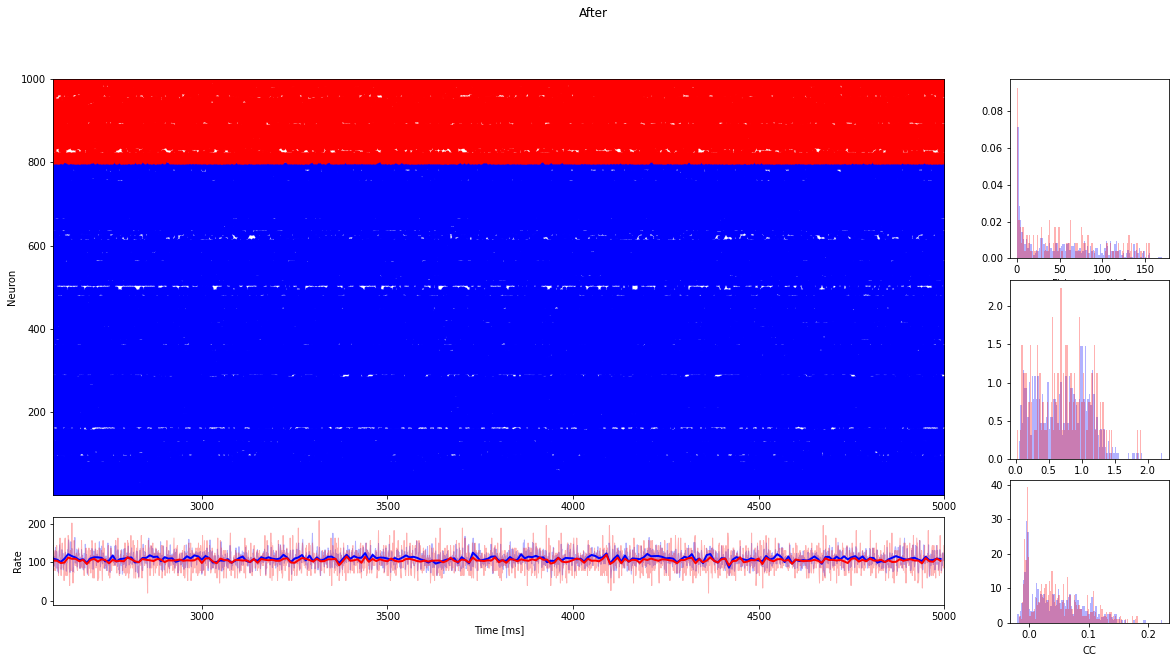

In [23]:
sim_time = 5000.
perturbation_time = 2500.
rate_scale = 2.
neuron_model = "iaf_psc_alpha"

reset_nest_kernel(seed=10, num_threads=16, dt=0.1)
neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1, wE=50., gamma=10.)

spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=perturbation_time)
e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=5000., start=0., stop=perturbation_time)
e_activity_pre, i_activity_pre = characterize_population_activity(e_activity, i_activity, start=0., transient=100., stop=perturbation_time, title='Before')

spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=perturbation_time, stop=sim_time)
e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=5000.*rate_scale, start=perturbation_time, stop=sim_time)

e_activity_post, i_activity_post = characterize_population_activity(e_activity, i_activity, start=perturbation_time, transient=100., stop=sim_time, title='After')

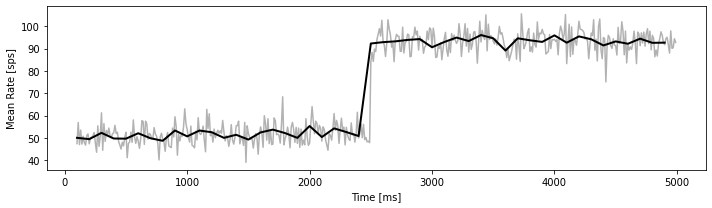

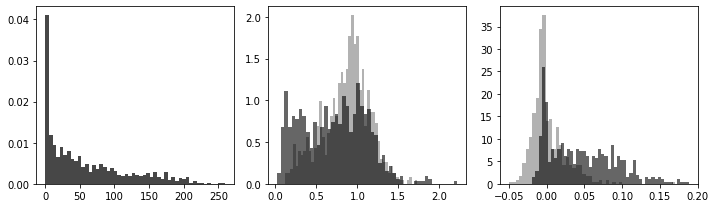

In [24]:
network_activity_pre = e_activity_pre.copy()
network_activity_pre.concatenate(i_activity_pre)

network_activity_post = e_activity_post.copy()
network_activity_post.concatenate(i_activity_post)

network_activity = network_activity_pre.copy()
network_activity.merge(network_activity_post)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(network_activity.time_axis(10.)[:-1], network_activity.firing_rate(10., average=True), c='k', alpha=0.3)
ax.plot(network_activity.time_axis(100.)[:-1], network_activity.firing_rate(100., average=True), c='k', lw=2)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Mean Rate [sps]")
plt.tight_layout()

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
rates_pre = np.array(network_activity_pre.mean_rates())
rates_post = np.array(network_activity_pre.mean_rates())
cvs_pre = network_activity_pre.cv_isi()
cvs_post = network_activity_post.cv_isi()
ccs_pre = network_activity_pre.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True)
ccs_post = network_activity_post.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True)

_ = ax[0].hist(rates_pre[rates_pre!=0.], color='k', histtype='stepfilled', alpha=0.3, density=True, bins=50)
_ = ax[0].hist(rates_post[rates_post!=0.], color='k', histtype='stepfilled', alpha=0.6, density=True, bins=50)

_ = ax[1].hist(cvs_pre[~np.isnan(cvs_pre)], color='k', histtype='stepfilled', alpha=0.3, density=True, bins=50)
_ = ax[1].hist(cvs_post[~np.isnan(cvs_post)], color='k', histtype='stepfilled', alpha=0.6, density=True, bins=50)

_ = ax[2].hist(ccs_pre[~np.isnan(ccs_pre)], color='k', histtype='stepfilled', alpha=0.3, density=True, bins=50)
_ = ax[2].hist(ccs_post[~np.isnan(ccs_post)], color='k', histtype='stepfilled', alpha=0.6, density=True, bins=50)

plt.tight_layout()

* Compare the different neuron models: does any of the networks recover the initial firing rate? If so, what is the time constant of the recovery process? 

### **4. Signal Representation**

By introducing longer timescales in the neuron dynamics, it has been hypothesized that intrinsic adaptation mechanisms may improve the circuit's ability to internally represent a dynamic input signal (see e.g. [[2]]). In this example, we will quantify the impact of the different adaptation mechanisms in the system's representation capacity. 

In [25]:
from helper import generate_input, convolve_spk, compute_capacity
from sklearn.decomposition import PCA

In these experiments, the network is driven by a time-varying signal $u(t)$ whose values are i.i.d. from a uniform distribution.  

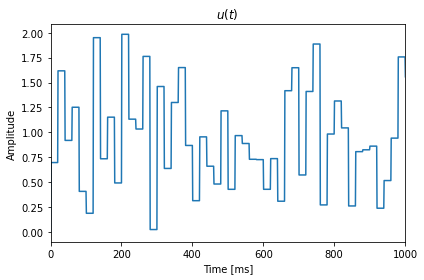

In [31]:
step_duration = 20.   # duration of each step [ms]
scale = 10000.         # input scaling factor [Hz]
num_steps = 100       # number of unique input values
dt = 1.               # input resolution [ms]

sig, times, inp_times, inp_amplitudes = generate_input(num_steps=num_steps, step_duration=step_duration, resolution=dt, scale=scale)

fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')
fig.tight_layout()

In [32]:
def stimulus_representation(neuron_model, input_times, input_amplitudes, sig):
    sim_time = num_steps*step_duration

    reset_nest_kernel(seed=10, num_threads=16, dt=0.1)
    
    if neuron_model == "aeif_cond_alpha":
        wE, gamma = 2.5, 5.
    else:
        wE, gamma = 15., 10.
    
    neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1, wE=wE, gamma=gamma)
    spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=sim_time)
    
    # create inhomogeneous poisson generator (time-dependent input signal)
    stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
    nest.SetStatus(stim_pgen, params={'rate_times': input_times, 'rate_values': input_amplitudes})
    nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
    nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)
    
    nest.Simulate(sim_time)
    
    activity = nest.GetStatus(spikes_e, 'events')[0]
    recorded_neurons = np.unique(activity['senders'])
    filter_tau = 20. # [ms]
    states = convolve_spk(activity['times'], activity['senders'], recorded_neurons, sim_time, filter_tau, dt)
    
    estimate, capacity, error, norm = compute_capacity(states, sig[:-1])
    print("\n####### {0} ####### \nCapacity={1}, MSE={2}".format(neuron_model, str(capacity), str(error)))
    
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle('{0} Representation Accuracy [C={1}]'.format(neuron_model, str(capacity)))
    ax11 = fig.add_subplot(211)
    ax12 = fig.add_subplot(212, sharex=ax11)
    ax11.plot(activity['times'], activity['senders'], '.k', markersize=1)
    ax11.set_xlim([0., sim_time])
    ax12.plot(times, sig, 'r', linewidth=2)
    ax12.plot(times[:-1], estimate, 'k', linewidth=1)
    ax12.set_xlabel(r'Time [ms]')
    plt.show()
    
    return estimate, capacity, error

Let's evaluate the representation capacity of balanced networks composed of the different neuron types developed.


####### iaf_psc_alpha ####### 
Capacity=0.8099466741820728, MSE=0.08221611342998679


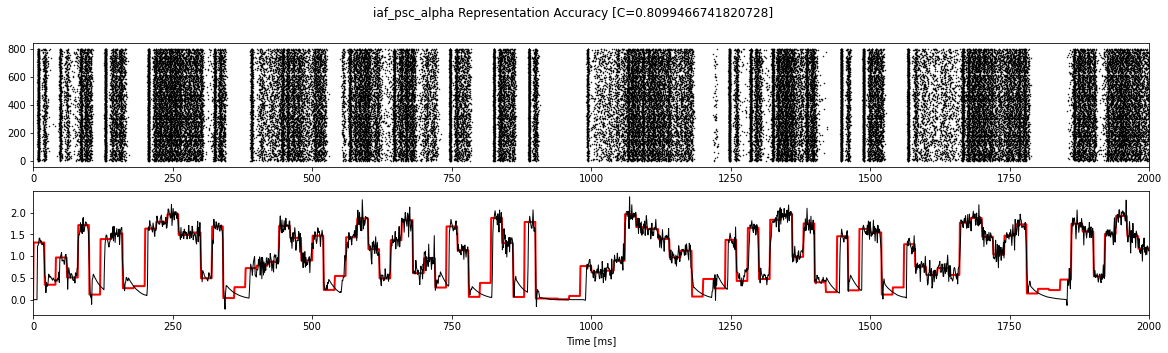


####### iaf_cond_exp_sfa_rr ####### 
Capacity=0.930285618488706, MSE=0.02813355444575242


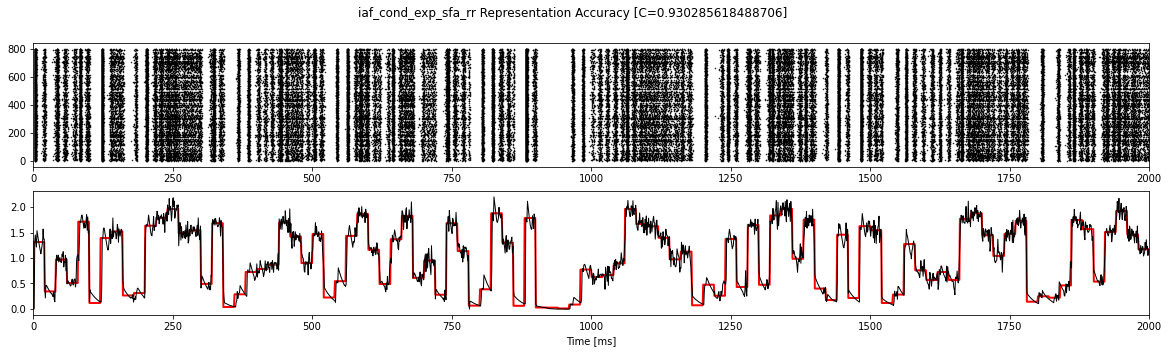


####### aeif_cond_alpha ####### 
Capacity=0.5280381889198336, MSE=0.2514849898155506


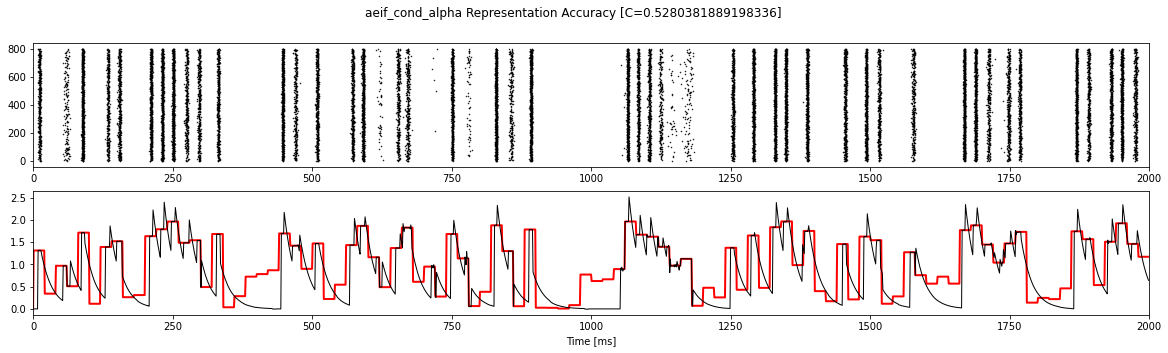

In [33]:
neuron_models = ["iaf_psc_alpha", "iaf_cond_exp_sfa_rr", "aeif_cond_alpha"]
sig, times, inp_times, inp_amplitudes = generate_input(num_steps=num_steps, step_duration=step_duration, resolution=dt, scale=scale)

c = []
e = []
for neuron in neuron_models:
    z_hat, cap, err = stimulus_representation(neuron, inp_times, inp_amplitudes, sig)
    c.append(cap)
    e.append(err)

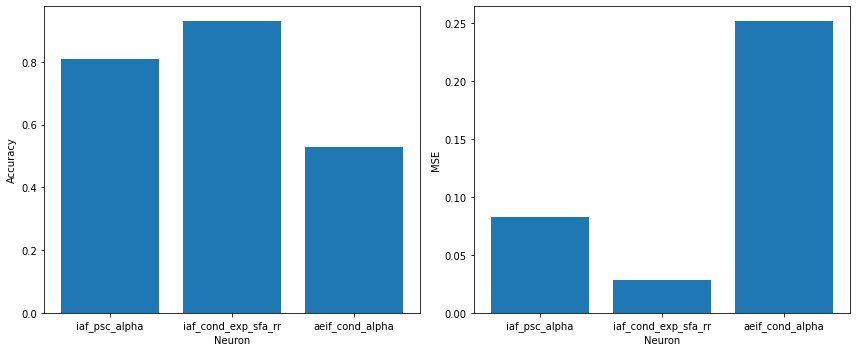

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(np.arange(len(neuron_models)), c)
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Neuron")
ax[0].set_xticks(np.arange(len(neuron_models)))
ax[0].set_xticklabels(neuron_models)
ax[1].bar(np.arange(len(neuron_models)), e)
ax[1].set_xticks(np.arange(len(neuron_models)))
ax[1].set_ylabel("MSE")
ax[1].set_xlabel("Neuron")
ax[1].set_xticklabels(neuron_models)
plt.tight_layout()